In [ ]:
import numpy as np
import astropy.units as u
import pandas as pd

In [1]:
# VHS J125601.92-125723.9 Gaia DR3 source id:
A_sourceid = 3526198184723289472
# Distance
d = np.array([21.16,0.21]) #pc
# Observation epoch:
epoch = 2019.853
# Masses:
Mhost = np.array([0.141,0.009]) #Msun
Mcomp = np.array([0.010,0.012]) #Msun
Mtot = np.array([0.152,0.010]) #Msun
# Measured companion-host separation:
DeltaRAcosd = np.array([-5025.6,2.0]) #mas, (comp-host)
DeltaDec = np.array([-6350.,9.]) #mas, (comp-host)
# Measured proper motions:
pmRAcosd = np.array([-10.7,0.6]) #mas/yr
pmDec = np.array([-0.6,0.7]) #mas/yr

# Set up the orbit fitter:

In [2]:
# Import the Fitter and FitOrbit objects:
from lofti_gaia.lofti import Fitter, FitOrbit

# Initialize the fitter object:
fitterobject = Fitter(A_sourceid,           # source id object 1
                      A_sourceid,           # source id object 2
                      Mhost,            # mass object 1
                      Mcomp,            # mass object 2
                      Norbits = 100000     # number of desired accepted orbits for the posterior orbit sample
                     )



            that the source might be an unresolved binary or experiencing acceleration 
            during the observation.  Orbit fit results may not be trustworthy.


In [3]:
# Some useful functions:
def masyr_to_kms(mas_yr,d):
    '''
    Convert from mas/yr -> km/s
     
    Args:
        mas_yr (array): velocity in mas/yr
        plx (tuple,float): parallax, tuple of (plx,plx error)
    Returns:
        array : velocity in km/s
    
    Written by Logan Pearce, 2019
    '''
    #d = distance(*plx)
    # convert mas to km:
    km_s = [((mas_yr[0]*u.mas.to(u.arcsec)*d[0])*u.AU).to(u.km) , 
            ((mas_yr[1]*u.mas.to(u.arcsec)*d[0])*u.AU).to(u.km)]
    # convert yr to s:
    km_s = [(km_s[0].value)*(u.km/u.yr).to(u.km/u.s) , (km_s[1].value)*(u.km/u.yr).to(u.km/u.s)]
    
    return km_s

def to_polar(dRA,dDec):
    ''' Converts RA/Dec [deg] of two binary components into separation and position angle of B relative 
        to A [mas, deg]

    Args:
        RAa, RAb, Deca, Decb (flt): RA/Dec of each object in deg
    Returns:
        tuple, flt: separation in mas and position angle in degrees from North

    Written by Logan Pearce, 2019
    '''
    try:
        r = np.sqrt( (dRA ** 2) + (dDec ** 2) )
        p = (np.degrees( np.arctan2(dDec.value,-dRA.value) ) + 270.) % 360.
        p = p*u.deg
    except:
        r = np.sqrt( (dRA ** 2) + (dDec ** 2) )
        p = (np.degrees( np.arctan2(dDec,-dRA) ) + 270.) % 360.
        p = p
    
    return r, p

def MonteCarloIt(thing, N = 10000):
    ''' 
    Generate a random sample of size = N from a 
    Gaussian centered at thing[0] with std thing[1]
    
    Args:
        thing (tuple, flt): tuple of (value,uncertainty).  Can be either astropy units object \
            or float
        N (int): number of samples
    Returns:
        array: N random samples from a Gaussian.

    Written by Logan Pearce, 2020
    '''
    try:
        out = np.random.normal(thing[0].value,thing[1].value,N)
    except:
        out = np.random.normal(thing[0],thing[1],N)

    return out

# Reassign orbit fitter variables:
We are going to use the infrastructure of LOFTI to do the obrit fit, but since the companion is not in Gaia, we are going to override the automatically assigned variables with the ones we've measured for the companion relative to the host.

In [4]:

# reference epoch:
fitterobject.ref_epoch = epoch

fitterobject.distance = d            # pc

fitterobject.deltaRA = DeltaRAcosd         # mas
fitterobject.deltaDec = DeltaDec      # mas

fitterobject.pmRA = masyr_to_kms(pmRAcosd,d)         # km/s
fitterobject.pmDec = masyr_to_kms(pmDec,d)       # km/s

# Compute separation/position angle using a Monte Carlo:
from lofti_gaia.loftitools import add_in_quad
dRA_array = MonteCarloIt(DeltaRAcosd)
dDec_array = MonteCarloIt(DeltaDec)
r, p = to_polar(dRA_array,dDec_array)
fitterobject.sep = tuple([np.mean(r), np.std(r)])             # mas
fitterobject.pa = tuple([np.mean(p), np.std(p)])               # deg

fitterobject.sep_au = tuple([((fitterobject.sep[0]/1000)*fitterobject.distance[0]),
                             ((fitterobject.sep[1]/1000)*fitterobject.distance[0])])
fitterobject.sep_km = tuple([ fitterobject.sep_au[0]*u.au.to(u.km) , fitterobject.sep_au[1]*u.au.to(u.km)])

fitterobject.total_vel = [ add_in_quad([fitterobject.pmRA[0],fitterobject.pmDec[0]]) , 
                    add_in_quad([fitterobject.pmRA[1],fitterobject.pmDec[1]]) ]             # km/s
fitterobject.total_planeofsky_vel = fitterobject.total_vel.copy()                       # km/s

fitterobject.deltaRA,fitterobject.pmRA

(array([-5.0256e+03,  2.0000e+00]),
 [-1.0732993985895123, 0.060185013005019376])

# Run the orbit fit:

In [5]:
# run orbit fit:
orbits = FitOrbit(fitterobject)

# get fit results:
results = orbits.results

Saving orbits in FitResults.2022.07.21.12.26.45.txt
inital chi min 2.954407451780772
100% (99501 of 100000): |####################|  Done...
100% (99502 of 100000): |####################|  Done...
100% (99502 of 100000): |####################|  Done...
100% (99502 of 100000): |####################|  Done...
100% (99502 of 100000): |####################|  Done...
100% (99505 of 100000): |####################|  Done...
100% (99505 of 100000): |####################|  Done...
100% (99505 of 100000): |####################|  Done...
100% (99506 of 100000): |####################|  Done...
100% (99507 of 100000): |####################|  Done...
100% (99507 of 100000): |####################|  Done...
100% (99508 of 100000): |####################|  Done...
100% (99511 of 100000): |####################|  Done...
100% (99511 of 100000): |####################|  Done...
100% (99511 of 100000): |####################|  Done...
100% (99512 of 100000): |####################|  Done...
100% (99513 of 1000

100% (99640 of 100000): |####################|  Done...
100% (99641 of 100000): |####################|  Done...
100% (99641 of 100000): |####################|  Done...
100% (99642 of 100000): |####################|  Done...
100% (99644 of 100000): |####################|  Done...
100% (99644 of 100000): |####################|  Done...
100% (99644 of 100000): |####################|  Done...
100% (99645 of 100000): |####################|  Done...
100% (99646 of 100000): |####################|  Done...
100% (99648 of 100000): |####################|  Done...
100% (99648 of 100000): |####################|  Done...
100% (99651 of 100000): |####################|  Done...
100% (99651 of 100000): |####################|  Done...
100% (99651 of 100000): |####################|  Done...
100% (99652 of 100000): |####################|  Done...
100% (99652 of 100000): |####################|  Done...
100% (99652 of 100000): |####################|  Done...
100% (99653 of 100000): |####################|  

100% (99759 of 100000): |####################|  Done...
100% (99760 of 100000): |####################|  Done...
100% (99760 of 100000): |####################|  Done...
100% (99761 of 100000): |####################|  Done...
100% (99762 of 100000): |####################|  Done...
100% (99764 of 100000): |####################|  Done...
100% (99765 of 100000): |####################|  Done...
100% (99766 of 100000): |####################|  Done...
100% (99766 of 100000): |####################|  Done...
100% (99766 of 100000): |####################|  Done...
100% (99766 of 100000): |####################|  Done...
100% (99767 of 100000): |####################|  Done...
100% (99768 of 100000): |####################|  Done...
100% (99769 of 100000): |####################|  Done...
100% (99770 of 100000): |####################|  Done...
100% (99771 of 100000): |####################|  Done...
100% (99772 of 100000): |####################|  Done...
100% (99772 of 100000): |####################|  

100% (99891 of 100000): |####################|  Done...
100% (99891 of 100000): |####################|  Done...
100% (99891 of 100000): |####################|  Done...
100% (99891 of 100000): |####################|  Done...
100% (99894 of 100000): |####################|  Done...
100% (99894 of 100000): |####################|  Done...
100% (99895 of 100000): |####################|  Done...
100% (99895 of 100000): |####################|  Done...
100% (99898 of 100000): |####################|  Done...
100% (99898 of 100000): |####################|  Done...
100% (99900 of 100000): |####################|  Done...
100% (99900 of 100000): |####################|  Done...
100% (99902 of 100000): |####################|  Done...
100% (99903 of 100000): |####################|  Done...
100% (99903 of 100000): |####################|  Done...
100% (99903 of 100000): |####################|  Done...
100% (99903 of 100000): |####################|  Done...
100% (99903 of 100000): |####################|  

# Make results plots:

In [1]:
from lofti_gaia import Results, Stats
# Make a new results object and load previous results:
results = Results()

file='FitResults.2022.07.21.12.26.45.txt'

epoch = 2019.853

orbits = pd.read_table(file, comment = '#', delim_whitespace=True,
                       names = ['sma','period','orbit phase','t_0','ecc','incl','argp','lan','m_tot','dist',
                                'chi2','ln(prob)','ln(randn)'])
results.sma = orbits['sma']
results.period = orbits['period']
results.orbit_fraction = orbits['orbit phase']
results.t0 = orbits['t_0']
results.ecc = orbits['ecc']
results.inc = orbits['incl']
results.aop = orbits['argp'] % 360
from lofti_gaia.loftitools import limit_to_180deg
results.lan = orbits['lan'] % 360
results.mtot = orbits['m_tot']
results.distance = orbits['dist']
results.chi2 = orbits['chi2']
results.lnprob = orbits['ln(prob)']
results.lnrand = orbits['ln(randn)']

np.shape(results.sma)

(100000,)

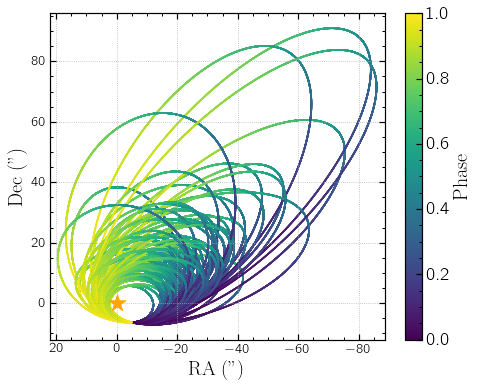

In [2]:
plotorbits = results.PlotOrbits(size = 100, ref_epoch = epoch)

In [4]:
plotorbits.axes[1].tick_params(labelsize=20)
plotorbits.axes[0].tick_params(labelsize=23)
plotorbits.axes[0].set_xlabel(r'$\Delta$RA (")',fontsize=27)
plotorbits.axes[0].set_ylabel('$\Delta$DEC (")',fontsize=27)
plotorbits.savefig('orbitplot-100.png',dpi=300, bbox_inches='tight')

In [14]:
from lofti_gaia import Results
results2 = Results(limit_aop = True)
results2.LoadResults("FitResults.2022.07.21.12.26.45.pkl")
results2.lan = results2.orbits[:,7] % 360

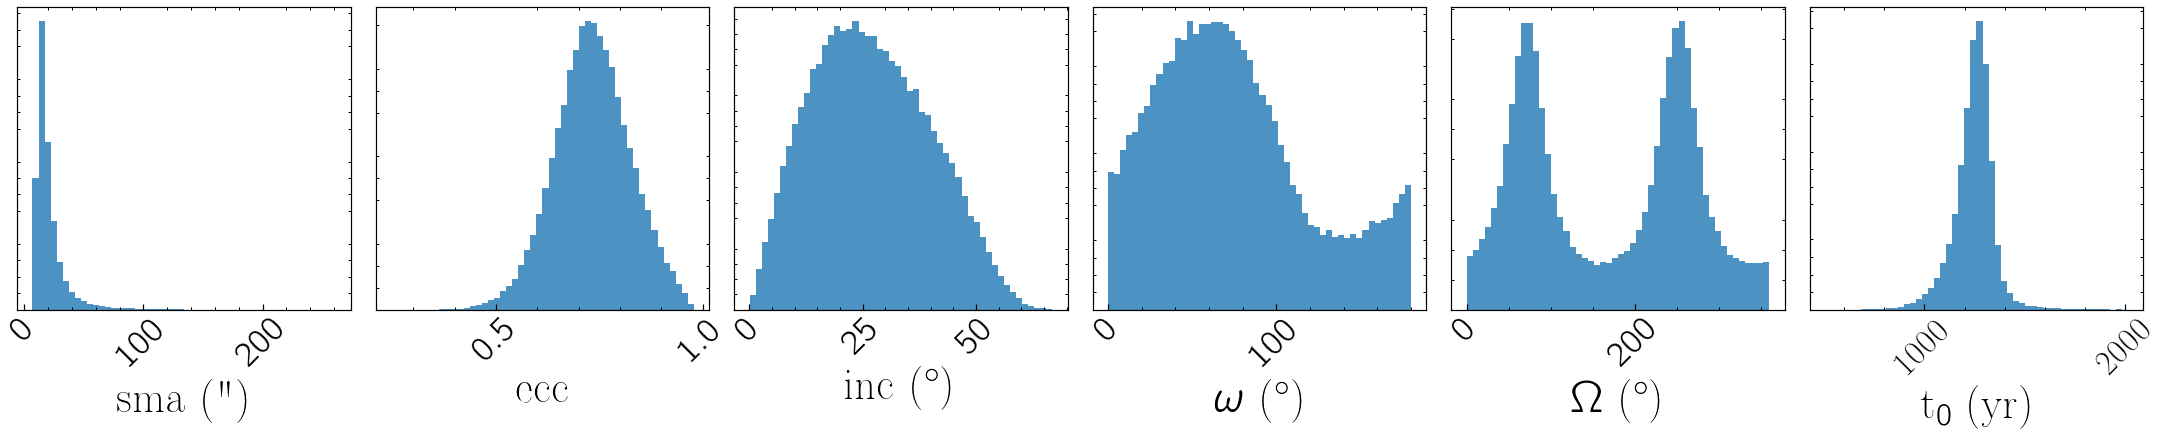

In [34]:
hists = results2.PlotHists()
from matplotlib.ticker import FormatStrFormatter
# For example, change t0 to scientific notation:
hists.axes[-1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
labels = ['sma (")', 'ecc', 'inc ($^\circ$)',
                  '$\omega$ ($^\circ$)', '$\Omega$ ($^\circ$)', 't$_0$ (yr)']
for i,ax in enumerate(hists.axes):
    ax.tick_params(labelsize=35)
    ax.set_xlabel(labels[i],fontsize=45)
#hists.axes[-1].axvline(x=epoch,ls=':',color='grey')   
hists.savefig('VHS1256AB-b/histplot.png',dpi=300, bbox_inches='tight')

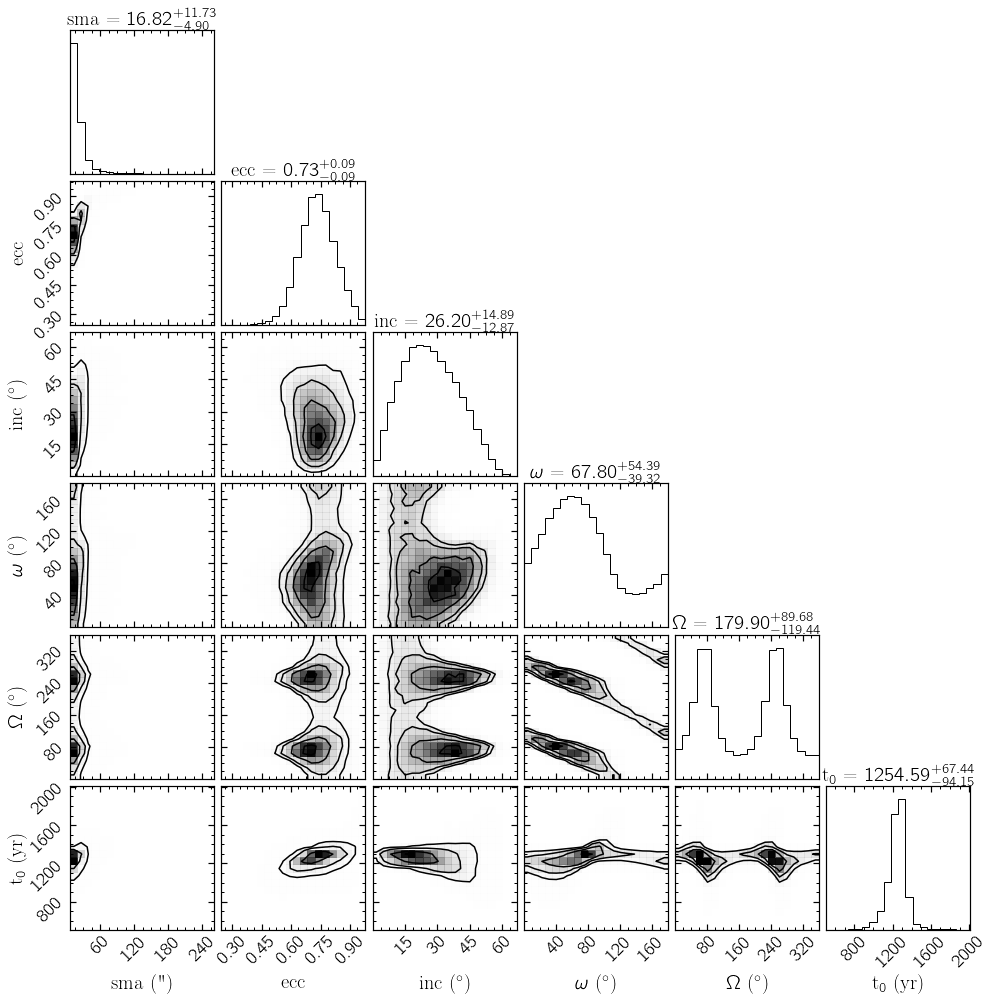

In [35]:
import corner

params = np.array([results2.sma,results2.ecc,results2.inc,results2.aop,results2.lan,results2.t0])

titles = np.array(['sma', 'ecc', 'inc',
                  '$\omega$', '$\Omega$', 't$_0$'])
figure = corner.corner(params.T, labels=labels, titles = titles, show_titles=True, plot_datapoints=False,
                      fontsize=30)
figure.savefig('VHS1256AB-b/cornerplot.png',dpi=300, bbox_inches='tight')